<a href="https://colab.research.google.com/github/scaairesearch/da_cv_fer/blob/main/Bias_Evaluation_Inference_FER_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. get dataset / dataloader
3. get output
2. load model
4. get task accuracy
4. get demographic parity
5. get equality odds



## Cloning Repo, Installing dependencies

In [1]:
!pip install --upgrade Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 20.4 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.3.0 which is incompatible.


In [1]:
!git clone https://github.com/scaairesearch/da_cv_fer.git
import os
os.getcwd()
os.chdir('da_cv_fer')

Cloning into 'da_cv_fer'...
remote: Enumerating objects: 535, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 535 (delta 25), reused 0 (delta 0), pack-reused 483
Receiving objects: 100% (535/535), 45.02 MiB | 32.24 MiB/s, done.
Resolving deltas: 100% (299/299), done.


In [3]:

!pip install -q -r requirements.txt # -q is for quiet install
# for some reason the below does not get installed with requirements
!pip install -q opendatasets
!pip install -q facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# Installs from files
from da_cv_fer.data_config import DataConfig
from da_cv_fer.ds_sfew_crop import DatasetSFEWCROP

from da_cv_fer.ds_expw_crop_image_race import EXPWIMAGECROPRACE
from da_cv_fer.utils import *
from da_cv_fer.run_config import RunConfig


import os
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

from copy import deepcopy
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
import pandas as pd


## Initializing Configs

In [5]:

#initializing dataconfig, it tells us about dataset configuration and directory structure
dataconfig = DataConfig()

##  Dataset
- EXPW Crop Race Loader

In [6]:
# checking the mounted drive and mounting if not done
if not os.path.exists('/content/gdrive'):
  from google.colab import drive
  drive.mount('/content/gdrive')
else:
    print("Google Drive is already mounted.")

Mounted at /content/gdrive


In [7]:
# EXPWIMAGECROPRACE

expw_obj = EXPWIMAGECROPRACE(type='val',crop_at_runtime=False)

expw_val_ds = expw_obj.get_dataset()
expw_val_loader = expw_obj.get_dataloader()
print(f' length of EXPW dataset : {len(expw_val_loader.dataset)} , {len(expw_val_ds)}')

---NOT CROPPING AT RUNTIME --
*** Starting creation of dataset based on RACE data ***
pickle_raceds_crop_list_path:  /content/gdrive/MyDrive/CV_FER/dataset/expw_raceds_crop_image_dict.pkl
self.list_img_label:  [('amazed_american_212.jpg', 0), ('angry_black_177.jpg', 0), ('angry_black_3.jpg', 0), ('angry_black_531.jpg', 0), ('angry_black_64.jpg', 0)]
expw_raceds_dict_list: [('amazed_american_212.jpg', 'African', 0), ('angry_black_177.jpg', 'African', 0), ('angry_black_3.jpg', 'African', 0), ('angry_black_531.jpg', 'African', 0), ('angry_black_64.jpg', 'African', 0)]
expw_raceds_dict_list_selected: 8458, [('amazed_american_212.jpg', 'African', 0), ('angry_black_177.jpg', 'African', 0), ('angry_black_3.jpg', 'African', 0), ('angry_black_531.jpg', 'African', 0), ('angry_black_64.jpg', 'African', 0)]
size of dataset (list_img_label): 8458
*** Completed creation of dataset based on RACE data ***
---NOT CROPPING AT RUNTIME--, flag_create_crop_contents value: False
Directory created: dataset/e

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


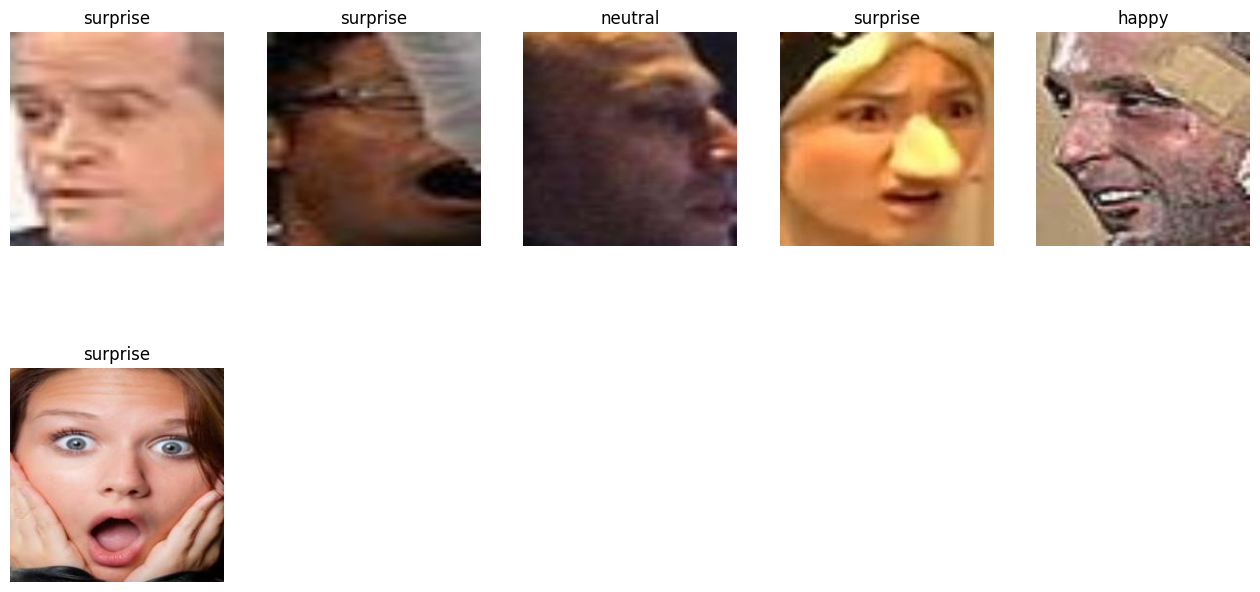

In [8]:
show_batch(expw_val_loader,expw_val_ds.labels,6,normalized=False)

## Load Models

### Name of the *models*

In [9]:
non_dann_model_sfew_expw_name = 'non_dann_sfew_expw_08_04.pt'
dann_model_sfew_expw_name ='dann_sfew_expw_08_04.pt'
ewc_dann_model_sfew_expw_name = 'ewc_dann_sfew_expw_08_04.pt'

## Model initialization and structure

In [10]:
import torch
import torch.nn as nn
from torch.autograd import Function
import torch.nn.functional as F


class Vgg_vd_face_sfew_dag(nn.Module):

    def __init__(self):
        super(Vgg_vd_face_sfew_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=[7, 7], stride=(1, 1))
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(in_features=4096, out_features=7, bias=True)

    def forward(self, data):
        x1 = self.conv1_1(data)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31 = self.pool5(x30)
        x32 = self.fc6(x31) # this is a conv layer, this is the output we need
        x33_preflatten = self.relu6(x32)
        x33 = x33_preflatten.view(x33_preflatten.size(0), -1)
        x34 = self.fc7(x33)
        x35 = self.relu7(x34)
        prediction = self.fc8(x35)
        return prediction


def vgg_vd_face_sfew_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_vd_face_sfew_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

model_pretrained = vgg_vd_face_sfew_dag(weights_path="/content/gdrive/MyDrive/CV_FER/weights/vgg_vd_face_sfew_dag.pth")

In [11]:
model_pretrained

Vgg_vd_face_sfew_dag(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (pool1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (pool2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU()
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU()
  (pool3): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_m

In [12]:
import torch.nn as nn
import torch
from torch.autograd import Function
import torch.nn.functional as F

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class DANN_VGG(nn.Module):
    def __init__(self,
                 model_pretrained = model_pretrained,
                 num_classes=7,
                 dropout_rate = 0.1,
                 ):
        super(DANN_VGG, self).__init__()
        #---------------------Feature Extractor Network------------------------#
        self.feature_extractor = nn.Sequential(*list(model_pretrained.children())[:-4])

        #---------------------Class Classifier------------------------#
        list_class_classifer = list(model_pretrained.children())[-4:]
        list_class_classifer.insert(2, nn.Dropout(dropout_rate))
        # self.class_classifier = nn.Sequential(*list(model_pretrained.children())[-4:])
        self.class_classifier = nn.Sequential(*list_class_classifer)



        #---------------------Domain Classifier------------------------#

        self.domain_classifier = nn.Sequential(nn.ReLU(),
                                               nn.Linear(4096, 4096),
                                               nn.Dropout(dropout_rate),
                                               nn.ReLU(),
                                               nn.Linear(4096, 2)
                                               )

        # Initialize the 4096,4096 to pre-trained
        pretrained_weights = model_pretrained.fc7.weight
        pretrained_biases = model_pretrained.fc7.bias
        with torch.no_grad():
          self.domain_classifier[1].weight.copy_(pretrained_weights)
          self.domain_classifier[1].bias.copy_(pretrained_biases)


    def forward(self, input_data, alpha = 0.0):
        features = self.feature_extractor(input_data)
        # print("features.shape......", features.shape)
        features = features.view(-1,features.size(1))
        # print("features.shape after view......", features.shape)

        reverse_features = GradientReversalFn.apply(features,alpha)

        class_output = self.class_classifier(features)
        domain_output = self.domain_classifier(reverse_features)

        return class_output, domain_output, features

### Loading **Models**

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [14]:
dataconfig_inference=DataConfig()

# MODEL_DIR = dataconfig_inference.MODEL_DIR

# NON_DANN_SFEW_DIR = dataconfig_inference.NON_DANN_SFEW_DIR
# DANN_SFEW_EXPW_DIR = dataconfig_inference.DANN_SFEW_EXPW_DIR
# EWC_DANN_SFEW_EXPW_DIR = dataconfig_inference.EWC_DANN_SFEW_EXPW_DIR

In [15]:
# NON DANN
non_dann_model_inference = DANN_VGG(model_pretrained = model_pretrained, num_classes=7) # skeleton copy
NON_DANN_SFEW_DIR =  Path(dataconfig_inference.MODEL_DIR,"non_dann_sfew_expw")

try:
    non_dann_model_inference.load_state_dict(torch.load(Path(NON_DANN_SFEW_DIR, non_dann_model_sfew_expw_name),
                                                        map_location=torch.device(device)))
    print(f'{non_dann_model_sfew_expw_name} locked and loaded')
except Exception as e:
    print(e)
    print(f' problem in loading {non_dann_model_sfew_expw_name}')

# DANN
dann_model_sfew_expw_inference = DANN_VGG(model_pretrained = model_pretrained, num_classes=7) # skeleton copy
DANN_SFEW_EXPW_DIR = dataconfig_inference.DANN_SFEW_EXPW_DIR # Path(self.MODEL_DIR,"dann_sfew_expw")
try:
    dann_model_sfew_expw_inference.load_state_dict(torch.load(Path(DANN_SFEW_EXPW_DIR, dann_model_sfew_expw_name),
                                                              map_location=torch.device(device)))
    print(f'{dann_model_sfew_expw_name} locked and loaded')
except Exception as e:
    print(e)
    print(f' problem in loading {dann_model_sfew_expw_name}')

# EWC DANN
ewc_dann_model_sfew_expw_inference = DANN_VGG(model_pretrained = model_pretrained, num_classes=7)#,backbone='resnet18', dropout=0.1) # skeleton copy
EWC_DANN_SFEW_EXPW_DIR = dataconfig_inference.EWC_DANN_SFEW_EXPW_DIR # Path(self.MODEL_DIR,"ewc_dann_sfew_expw")
print(dataconfig_inference.EWC_DANN_SFEW_EXPW_DIR)
try:
    ewc_dann_model_sfew_expw_inference.load_state_dict(torch.load(Path(EWC_DANN_SFEW_EXPW_DIR, ewc_dann_model_sfew_expw_name),
                                                              map_location=torch.device(device)))
    print(f'{ewc_dann_model_sfew_expw_name} locked and loaded')
except Exception as e:
    print(e)
    print(f' problem in loading {ewc_dann_model_sfew_expw_name}')


non_dann_sfew_expw_08_04.pt locked and loaded
dann_sfew_expw_08_04.pt locked and loaded
/content/gdrive/MyDrive/CV_FER/models/ewc_dann_sfew_expw
ewc_dann_sfew_expw_08_04.pt locked and loaded


In [16]:
labels_map={"0":"Angry",
"1":"Disgust",
"2":"Fear",
"3":"Happy",
"4":"Sad",
"5":"Surprise",
"6":"Neutral"}

labels_map2={"Angry":"0",
"Disgust": "1",
"Fear":"2",
"Happy":"3",
"Sad":"4",
"Surprise":"5",
"Neutral":"6"}

In [45]:

#@title Typical Test Function
#TODO : move this to common file

def get_correct_predictions(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    print(prediction.shape, labels.shape)
    print(prediction)
    print(prediction.argmax(dim=1))
    print(labels)
    print(labels.argmax(dim=1))
    return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item() #.argmax(dim=1)

def test_model_race(model, device, test_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss(),
               result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion']) ):
    #model, device, test_loader, criterion, result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion'])
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0

   # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, (data, target, name, race) in enumerate(test_loader):

            # Put the images and labels on the selected device
            data, target = data.to(device), target.to(device)

            # Pass the images to the output and get the model predictions
            class_output, _ , _ = model(data)
            print("class output",class_output.shape)
            print("target ",target.shape)
            class_loss = class_loss_function(class_output, target)  # sum up batch loss
            test_loss += class_loss.item()
            # Sum up batch correct predictions
            correct += get_correct_predictions(class_output, target)

            for i in range(0,len(name)):
                result_row={'image':name[i] ,'gt_emotion':labels_map[str(target[i].argmax(dim=1).item())], 'gt_race':race[i], 'p_emotion':labels_map[str(class_output.argmax(dim=1)[i].item())]}
                result=result.append(result_row, ignore_index=True)


    # Calculate test loss for a epoch
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(test_loader.dataset),
        accuracy))


    return correct, test_loss, accuracy, result

In [43]:
# result_col = ['image','gt_emotion', 'gt_race', 'p_emotion']
# result = pd.DataFrame(columns=result_col)
# result

In [46]:
non_dann_correct, non_dann_test_loss, non_dann_accuracy, non_dann_result = test_model_race(model = non_dann_model_inference.to(device),
                                                                                           device= device,
                                                                                           test_loader = expw_val_loader,
                                                                                           mode= 'test',
                                                                                           class_loss_function = nn.CrossEntropyLoss(),
                                                                                           result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion'])
                                                                                           )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


class output torch.Size([16, 7])
target  torch.Size([16, 7])
torch.Size([16, 7]) torch.Size([16, 7])
tensor([[ 2.4906e-01, -5.6474e-01,  2.4110e-01, -4.9098e-01,  4.8136e-01,
         -6.5276e-03,  9.1194e-02],
        [ 3.0939e-01, -5.5535e-01,  1.8916e-01, -3.4858e-01,  4.3748e-01,
         -6.0169e-02,  2.8375e-02],
        [ 2.5342e-01, -5.2698e-01,  1.8802e-01, -2.9363e-01,  4.0524e-01,
         -2.5288e-02, -4.6392e-04],
        [ 3.3108e-01, -5.3642e-01,  2.5870e-01, -4.8495e-01,  4.2046e-01,
         -5.3390e-02,  6.4960e-02],
        [ 3.0642e-01, -5.4747e-01,  1.6191e-01, -2.5588e-01,  4.0735e-01,
         -5.5177e-02, -1.6962e-02],
        [ 3.2666e-01, -5.2328e-01,  2.4882e-01, -5.0506e-01,  4.0449e-01,
         -2.9754e-02,  7.8902e-02],
        [ 2.8604e-01, -5.1349e-01,  1.2995e-01, -1.6844e-01,  3.7504e-01,
         -5.7502e-02, -5.1257e-02],
        [ 2.8263e-01, -5.5939e-01,  2.6818e-01, -4.7512e-01,  4.5531e-01,
         -2.9816e-02,  5.8587e-02],
        [ 2.8808e-0

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
non_dann_result

In [ ]:
dann_correct, dann_test_loss, dann_accuracy, dann_result = test_model_race(model = dann_model_sfew_expw_inference.to(device),
                                                                                           device= device,
                                                                                           test_loader = expw_val_loader,
                                                                                           mode= 'test',
                                                                                           class_loss_function = nn.CrossEntropyLoss(),
                                                                                           result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion'])
                                                                                           )

In [ ]:
dann_result

In [ ]:
ewc_dann_correct, ewc_dann_test_loss, ewc_dann_accuracy, ewc_dann_result = test_model_race(model = ewc_dann_model_sfew_expw_inference.to(device),
                                                                                           device= device,
                                                                                           test_loader = expw_val_loader,
                                                                                           mode= 'test',
                                                                                           class_loss_function = nn.CrossEntropyLoss(),
                                                                                           result=pd.DataFrame(columns=['image', 'gt_emotion', 'gt_race', 'p_emotion'])
                                                                                           )

In [ ]:
ewc_dann_result